In [4]:
import librosa
import librosa.display
from scipy import signal
from scipy import misc
import numpy as np
import matplotlib.pyplot as plt
import math
from PyHa.statistics import *
from PyHa.IsoAutio import *
from PyHa.visualizations import *

In [5]:
# Manual annotations
manual_df = pd.read_csv("ScreamingPiha_Manual_Labels.csv")
manual_df

,FOLDER,IN FILE,CLIP LENGTH,CHANNEL,OFFSET,DURATION,SAMPLING RATE,MANUAL ID
0,./TEST/,ScreamingPiha1.wav,32.6160,0,1.5448,2.1297,16000,bird
1,./TEST/,ScreamingPiha1.wav,32.6160,0,10.1638,0.8498,16000,bird
2,./TEST/,ScreamingPiha1.wav,32.6160,0,0.5549,0.9999,16000,bird
3,./TEST/,ScreamingPiha1.wav,32.6160,0,8.7739,0.8399,16000,bird
4,./TEST/,ScreamingPiha1.wav,32.6160,0,12.6335,1.9997,16000,bird
...,...,...,...,...,...,...,...,...
249,./TEST/,ScreamingPiha2.wav,33.9331,0,26.9274,1.7602,44100,bird
250,./TEST/,ScreamingPiha2.wav,33.9331,0,30.8178,0.7200,44100,bird
251,./TEST/,ScreamingPiha2.wav,33.9331,0,29.8677,0.9401,44100,bird
252,./TEST/,ScreamingPiha2.wav,33.9331,0,31.5378,1.9502,44100,bird


In [6]:
# Going to test with some Piha Calls, they usually peak a little bit above 5kHz, so I am going to bring the audio in
# at a 12kHz sample rate to reconstruct up to 6kHz
piha_clip_path = "data/test/ScreamingPiha1.wav"
y,sr = librosa.load(piha_clip_path,sr=12000)
S = np.abs(librosa.stft(y))

391392

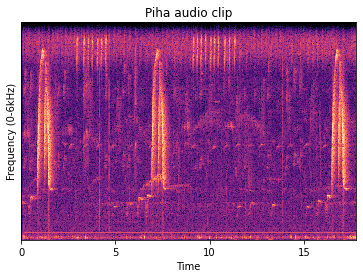

In [7]:
fig, ax = plt.subplots()
# Displaying a linear spectrogram. This y-limit is 6kHz.
# I really dislike the default settings found in Librosa for the x and y axis.
img = librosa.display.specshow(librosa.amplitude_to_db(S,ref=np.max), x_axis='time', ax=ax)
# It seems that 3s is a good time on this image.
plt.title("Piha audio clip")
plt.ylabel("Frequency (0-6kHz)")
len(y)

Text(0.5, 1.0, 'Piha Template')

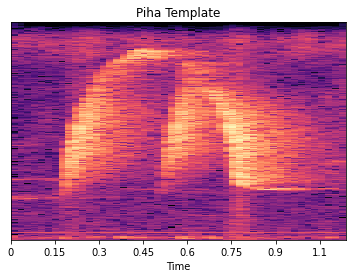

In [8]:
template = np.abs(librosa.stft(y[15000:40000]))
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(template,ref=np.max),x_axis='time',ax=ax)
plt.title("Piha Template")

In [9]:
# performing the sound cross-correlation
# This is very slow
corr = signal.correlate2d(S,template,boundary='symm',mode='same')
corr_reduced_max = np.amax(corr,axis=0)

# Time to figure out how to connect this 1D local score array back into the Steinberg technique
# Setting up the Isolation Parameters
isolation_parameters = {
    "technique" : "steinberg",
    "threshold_type" : "median",
    "threshold_const" : 2.0,
    "threshold_min" : 0.0,
    "bi_directional_jump" : 0.05,
    "window_size" : 1.0 
}
# "bi_directional_jump" : len(y[36000:55000])/sr 

test_df = steinberg_isolate(corr_reduced_max/max(corr_reduced_max),y,12000,"test_dir","test_file",isolation_parameters)
test_df

,FOLDER,IN FILE,CHANNEL,CLIP LENGTH,SAMPLE RATE,OFFSET,DURATION,MANUAL ID
0,test_dir,test_file,0,32.616,12000,0.607167,3.299500,bird
1,test_dir,test_file,0,32.616,12000,11.721417,3.299500,bird
2,test_dir,test_file,0,32.616,12000,29.265750,3.342083,bird


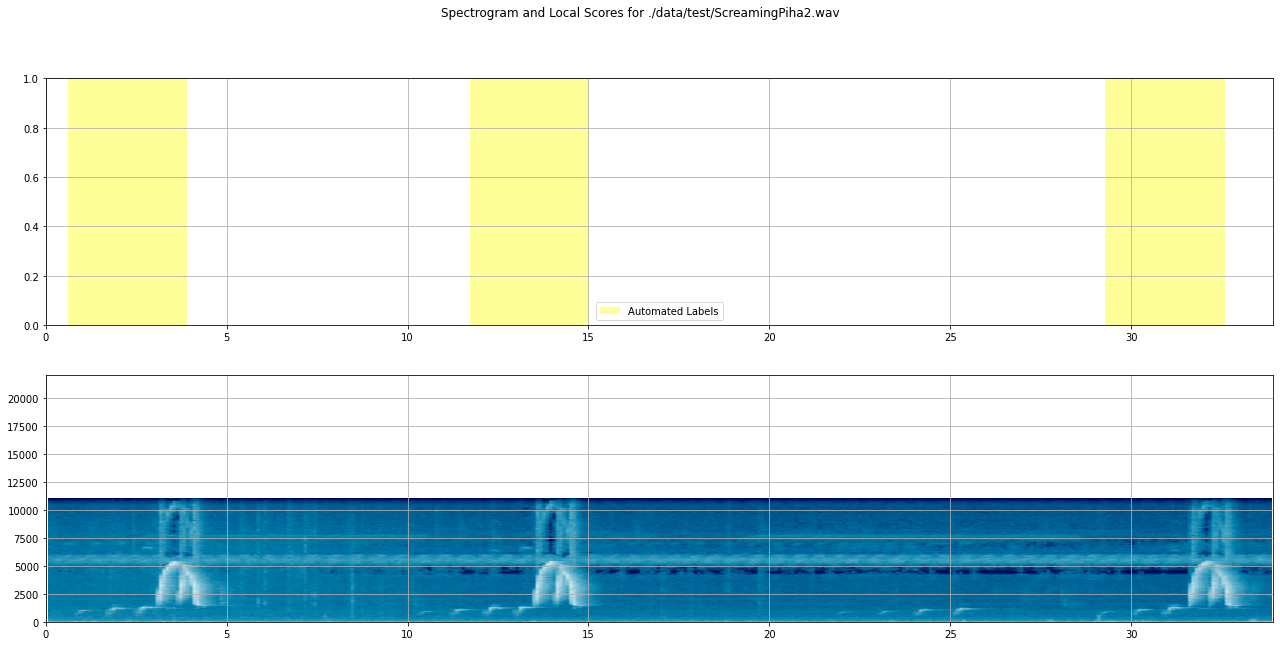

In [16]:
# The way Pyha is written right now, I need to pretend like these automated template matched annotations
# are human annotations. I wrote an issue to handle this later.

SIGNAL,SAMPLE_RATE = librosa.load("./data/test/ScreamingPiha2.wav")

if len(SIGNAL.shape) == 2:
        # averaging the two channels together
        SIGNAL = SIGNAL.sum(axis=1) / 2
        
# downsample the audio if the sample rate > 44.1 kHz
# Force everything into the human hearing range.

if SAMPLE_RATE > 44100:
    rate_ratio = 44100 / SAMPLE_RATE
    SIGNAL = scipy_signal.resample(
        SIGNAL, int(len(SIGNAL) * rate_ratio))
    SAMPLE_RATE = 44100
        
# local_score = (corr_reduced_max/max(corr_reduced_max))
local_line_graph(corr, "./data/test/ScreamingPiha2.wav", SAMPLE_RATE, SIGNAL, automated_df=test_df, premade_annotations_df=pd.DataFrame())

# local_score_visualization("./data/test/ScreamingPiha2.wav", premade_annotations_df = test_df) 

In [17]:
corr

array([[29507.645, 30547.64 , 32541.08 , ..., 63019.03 , 59518.145,
        57636.37 ],
       [28985.574, 30067.896, 32054.625, ..., 62537.574, 59091.34 ,
        56977.81 ],
       [28731.723, 29576.992, 31463.541, ..., 62127.113, 59009.28 ,
        56929.25 ],
       ...,
       [16743.178, 17200.18 , 17641.14 , ..., 23411.715, 22587.879,
        22659.41 ],
       [16779.697, 17228.72 , 17674.33 , ..., 23329.29 , 22573.291,
        22684.904],
       [16848.53 , 17293.457, 17673.049, ..., 23270.242, 22567.14 ,
        22673.729]], dtype=float32)